In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import unicodedata
import string
import re
import random
import torch

In [ ]:
data = pd.read_csv("data/data1.csv")

In [ ]:
data.head()

,Unnamed: 0,en,yo
0,0,The priest will then examine the contaminated ...,Kí àlùfáà wá yẹ ohun tí àrùn náà wà lára rẹ̀ w...
1,1,Become for me a rock fortress Where I can alwa...,Di àpáta ààbò fún mi Kí n lè máa ríbi wọ̀ nígb...
2,2,And I heard the voice out of heaven speaking a...,Mo sì gbọ́ ohùn láti ọ̀run tó tún ń bá mi sọ̀r...
3,3,"My son, do not forget my teaching, And may you...","Ọmọ mi, má gbàgbé ẹ̀kọ́ mi, Sì jẹ́ kí ọkàn rẹ ..."
4,4,“‘When a chieftain unintentionally sins by doi...,"“‘Tí ìjòyè kan bá ṣẹ̀ láìmọ̀ọ́mọ̀, tó ṣe ọ̀kan..."


## Tokenization
This section create a Language util class and function to make it easier to tokenize the language, since spacy does not have the tokenizer for the language. Thanks to pytorh [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) , some of their utility function makes it easier

In [ ]:
## Create a Language class to store  util functions
## such as index to word and word to index
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<blank>":0, "SOS":1,"EOS":2}
        self.word2count = {}
        self.index2word = {0:"<blank>", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
zdata = list(zip(data["en"].values,data["yo"])) ##zipped the two language together

In [ ]:
len(zdata)

20073

In [ ]:
zdata[0]

('The priest will then examine the contaminated item after it has been thoroughly washed. If the appearance of the contamination has not changed, even if the disease has not spread, it is unclean. You should burn it in the fire because it has been eaten away, either from its underside or from its outside.',
 'Kí àlùfáà wá yẹ ohun tí àrùn náà wà lára rẹ̀ wò lẹ́yìn tí wọ́n ti fọ̀\xa0ọ́ dáadáa. Tí ìrísí ibi tí àrùn náà wà kò bá yàtọ̀ sí ti tẹ́lẹ̀, bí àrùn náà ò tiẹ̀ ràn, aláìmọ́ ni. Ṣe ni kí ẹ fi iná sun ún torí ó ti jẹ ní inú tàbí ní ìta.')

In [ ]:
## Util function to make it easier to s
## group the language into output and input
def readLang(lang1,lang2,reverse=False):
    
    pairs = [[normalizeString(s) for s in dt] for dt in zdata]
    
    if reverse:
        pairs =  [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang,pairs

In [ ]:
MAX_LENGTH = 100

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLang(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra')
print(random.choice(pairs))

Read 20073 sentence pairs
Trimmed to 20073 sentence pairs
Counting words...
Counted words:
eng 10750
fra 5368
['the king then said to the man of the true god come home with me and take some food and let me give you a gift . ', 'leyin naa oba so fun eeyan olorun tooto naa pe je ka jo lo sile ki o le jeun ki n si fun o ni ebun . ']


In [ ]:
len(pairs)

20073

In [ ]:
## convert word to their index
def tokenize(lang,sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


In [ ]:
pairs2 = np.array(pairs) ## convert the pairs to numpy array

create the input lang `ENglish` tokenization

In [ ]:
input_token = list(map(lambda x: tokenize(input_lang,x),pairs2[:,0]))

In [ ]:
## tokenization for output lang
def tokenize2(lang,sentence):
    
    sent = "SOS" + " " + sentence + " " + "EOS"
    return [lang.word2index[word] for word in sent.split(' ')]

In [ ]:
output_token = list(map(lambda x: tokenize2(output_lang,x),pairs2[:,1]))

In [ ]:
pairs2[:,1][0]

'ki alufaa wa ye ohun ti arun naa wa lara re wo leyin ti won ti fo o daadaa . ti irisi ibi ti arun naa wa ko ba yato si ti tele bi arun naa o tie ran alaimo ni . se ni ki e fi ina sun un tori o ti je ni inu tabi ni ita .'

the input and out put lang is padded and converted to numpy array

In [ ]:
input_tokenPad = np.zeros((len(input_token),MAX_LENGTH))
output_tokenPad = np.zeros((len(output_token),MAX_LENGTH))

In [ ]:
for i,v in enumerate(input_token):
    
    for j, token in enumerate(v):
        
        input_tokenPad[i,j] = token

In [ ]:
for i,v in enumerate(output_token):
    
    for j, token in enumerate(v):
        
        output_tokenPad[i,j] = token

In [ ]:
output_tokenPad

array([[  1.,   3.,   4., ...,   0.,   0.,   0.],
       [  1.,  43.,  44., ...,   0.,   0.,   0.],
       [  1.,  61.,  25., ...,   0.,   0.,   0.],
       ...,
       [  1.,  38.,  94., ...,   0.,   0.,   0.],
       [  1.,  52.,  90., ...,   0.,   0.,   0.],
       [  1., 113.,   8., ...,   0.,   0.,   0.]])

In [ ]:
## we only want up to 20K rows------cause of batching
input_tokenPad1 = input_tokenPad[:20000]
output_tokenPad1 = output_tokenPad[:20000]

In [ ]:

from sklearn.model_selection import train_test_split


In [ ]:
#split the dataset into train, test and validation
train_eng, valid_eng,train_yor,valid_yor = train_test_split(input_tokenPad1,output_tokenPad1,test_size=0.2,shuffle=True)

Data Loader is created for the dataset to make batching easy

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_eng).long(),torch.from_numpy(train_yor).long())
valid_data = TensorDataset(torch.from_numpy(valid_eng).long(),torch.from_numpy(valid_yor).long())

batch_size = 100

train_loader= DataLoader(train_data,shuffle=True,batch_size=batch_size,)
valid_loader =DataLoader(valid_data,shuffle=True,batch_size=batch_size,)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print("shape of english", sample_x.device)


shape of english cpu


# **Transormer model**
This model is as it is from the [**NLP HARVARD** ](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)tutorial, with just small modification to fit our task

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

**Encoder and Decoder Stackss**

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

**Decoder**

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

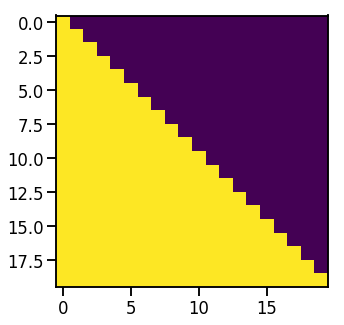

In [ ]:

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

**Attention**

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

**Position-wise Feed-forward**

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

**Embedding and softmax**

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

**Positional Encoding**

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

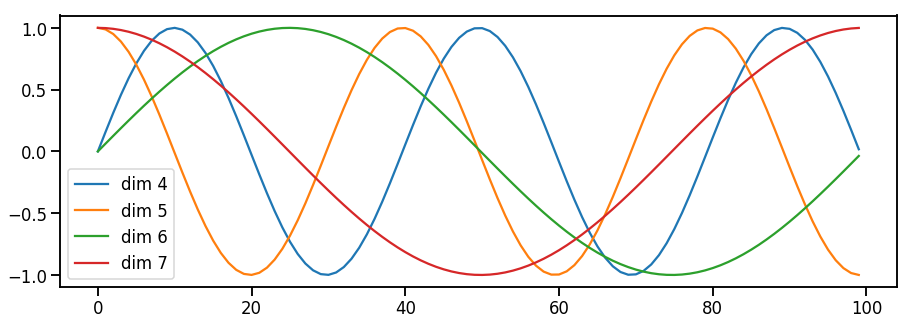

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

**FUll Model**

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
# Small example model.
tmp_model = make_model(10, 10, 2)
None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# **Training**

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, data in enumerate(data_iter):
        
        src, trg = data
        batch = Batch(src.cuda(),trg.cuda())
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

**optim**

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

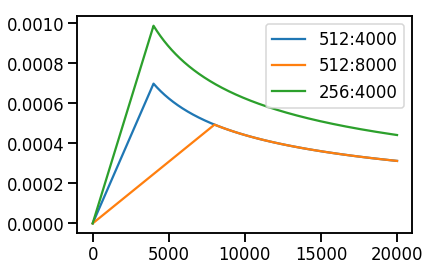

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

**label smoothing**

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

**Loss computation**

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

Training begins

In [ ]:
pad_idx = output_lang.word2index["<blank>"]
model = make_model(input_lang.n_words,output_lang.n_words,N=6)
model.cuda()
criterion = LabelSmoothing(size=output_lang.n_words,padding_idx=pad_idx,smoothing=0.1)
criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LabelSmoothing(
  (criterion): KLDivLoss()
)

In [ ]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
  model.train()
  
    
  run_epoch(train_loader,model,
           SimpleLossCompute(model.generator,criterion,model_opt))
  model.eval()
  print(run_epoch(valid_loader,model,
           SimpleLossCompute(model.generator,criterion,None)))

Epoch Step: 1 Loss: 7.000000 Tokens per Sec: 1440.000000
Epoch Step: 51 Loss: 6.000000 Tokens per Sec: 1390.000000
Epoch Step: 101 Loss: 5.000000 Tokens per Sec: 1385.000000
Epoch Step: 151 Loss: 4.000000 Tokens per Sec: 1385.000000
Epoch Step: 1 Loss: 4.000000 Tokens per Sec: 1511.000000
tensor(4, device='cuda:0')
Epoch Step: 1 Loss: 5.000000 Tokens per Sec: 1482.000000
Epoch Step: 51 Loss: 4.000000 Tokens per Sec: 1381.000000
Epoch Step: 101 Loss: 4.000000 Tokens per Sec: 1388.000000
Epoch Step: 151 Loss: 4.000000 Tokens per Sec: 1390.000000
Epoch Step: 1 Loss: 3.000000 Tokens per Sec: 1517.000000
tensor(3, device='cuda:0')
Epoch Step: 1 Loss: 4.000000 Tokens per Sec: 1537.000000
Epoch Step: 51 Loss: 3.000000 Tokens per Sec: 1393.000000
Epoch Step: 101 Loss: 3.000000 Tokens per Sec: 1383.000000
Epoch Step: 151 Loss: 3.000000 Tokens per Sec: 1380.000000
Epoch Step: 1 Loss: 3.000000 Tokens per Sec: 1521.000000
tensor(3, device='cuda:0')
Epoch Step: 1 Loss: 4.000000 Tokens per Sec: 1485

In [ ]:
for i, data in enumerate(valid_loader):
  
    src,trg = data
    batch = Batch(src.cuda(),trg.cuda())
    src = batch.src[:1]
    src_mask = (src != input_lang.word2index["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model.cuda(), src, src_mask, 
                        max_len=60, start_symbol=output_lang.word2index["SOS"])
    for i in range(0, src.size(1)):
        sym = input_lang.index2word[src[0, i].item()]
        if sym == "<blank>": break
        print(sym, end =" ")
    print()
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = output_lang.index2word[out[0, i].item()]
        if sym == "EOS": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(1)):
        
        sym = output_lang.index2word[batch.trg.data[0,i].item()]
        if sym == "EOS": break
        print(sym, end =" ")
    print()
    break

they also took all their possessions captured all their little children and their wives and plundered everything in the houses . 
Translation:	won tun mu gbogbo ohun ini won won gba gbogbo awon omo won ati awon iyawo won si n ko gbogbo ohun ini won . 
Target:	won tun ko gbogbo ohun ini won won mu gbogbo awon omo won keekeeke ati awon iyawo won won si ko gbogbo ohun to wa ninu ile won . 


In [ ]:
src[0,1]

tensor(3, device='cuda:0')

## Inference
the model is saved, and the the input lang and output lang is also saved.
```python
torch.save({
    "SRC": input_lang,
    "TGT": output_lang,
    "model": model.state_dict()
},path)
```

In [ ]:
path = "drive/My Drive/machine_tran/NMT1.pt"

In [ ]:
model_pt = torch.load(path)


In [ ]:
src = model_pt['SRC']
input_lang.

In [ ]:
model = make_model(input_lang.n_words,output_lang.n_words,N=6)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
model.eval()
m = model.cpu()
sent = "go".split()
src = torch.LongTensor([[input_lang.word2index[w] for w in sent]])
src = Variable(src)
src_mask = (src != input_lang.word2index["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=3, start_symbol=output_lang.word2index["SOS"])
print("Translation:", end="\t")
trans = "SOS "
for i in range(1, out.size(1)):
    sym = output_lang.index2word[out[0, i].item()]
    if sym == "EOS": break
    trans += sym + " "
print(trans)

Translation:	SOS lo ba 
